# Deep Convolutional GAN on MNIST
---

## Pre-Reqs

### Library imports

In [1]:
# Importing PyTorch
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

# Importing data processing and visualization libraries
import matplotlib.pyplot as plt
import numpy as np

# Importing OS for path checking
import os

### Check if GPU is available

In [2]:
# Using GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Downloading the MNIST dataset

In [3]:
# Transformation layers
transform_mnist = transforms.Compose([
                           transforms.Resize(28),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ])

# Downloading the MNIST dataset
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, 
                                         transform=transform_mnist)

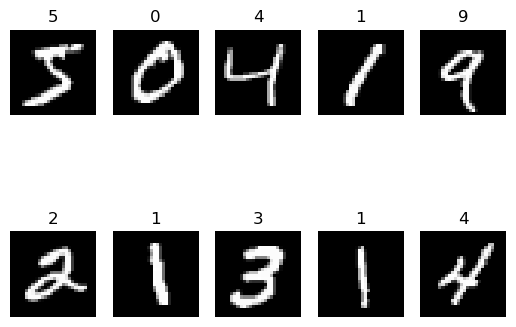

In [4]:
# Visualizing the dataset
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(mnist_train[i][0].squeeze().numpy(), cmap='gray')
    plt.title(str(mnist_train[i][1]))
    plt.axis('off')

## Creating the Model

### Creating a custom reshape layer

In [5]:
# Creating a custom reshape layer
class Reshape(nn.Module):
    def __init__(self, *args):
        
        # Inherits all that good stuff from nn.Module
        super(Reshape, self).__init__()

        # Shape is a tuple of integers
        self.shape = args

    def forward(self, x):
        # Returns a view of the input tensor
        return x.view(self.shape)

### Creating the Generator

In [6]:
class Generator(nn.Module):
    def __init__(self, coding_size=100):

        # Inherits all that good stuff from nn.Module
        super(Generator, self).__init__()

        # Defining the layers
        self.layer_stack = nn.Sequential(
            nn.Linear(coding_size, 128 * 7 * 7), # (N, 100) -> (N, 128 * 7 * 7)
            Reshape(-1, 128, 7, 7), # (N, 128 * 7 * 7) -> (N, 128, 7, 7)
            nn.BatchNorm2d(128), # 2D batch normalization
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # (N, 128, 7, 7) -> (N, 64, 14, 14)
            nn.ReLU(), # ReLU activation
            nn.BatchNorm2d(64), # 2D batch normalization
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1), # (N, 64, 14, 14) -> (N, 1, 28, 28)
            nn.Tanh() # Tanh activation
        )

    def forward(self, x):

        # Returns the output of the layer stack
        return self.layer_stack(x)

### Creating the Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self):

        # Inherits all that good stuff from nn.Module
        super(Discriminator, self).__init__()
        
        # Defining the layers
        self.layer_stack = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1), # (N, 1, 28, 28) -> (N, 64, 14, 14)
            nn.LeakyReLU(0.2), # Leaky ReLU activation
            nn.Dropout2d(0.3), # 2D dropout
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # (N, 64, 14, 14) -> (N, 128, 7, 7)
            nn.LeakyReLU(0.2), # Leaky ReLU activation
            nn.Dropout2d(0.3), # 2D dropout
            Reshape(-1, 128 * 7 * 7), # (N, 128, 7, 7) -> (N, 128 * 7 * 7)
            nn.Linear(128 * 7 * 7, 1), # (N, 128 * 7 * 7) -> (N, 1)
            nn.Sigmoid() # Sigmoid activation
        )

    def forward(self, x):

        # Returns the output of the layer stack
        return self.layer_stack(x)

### Initialising both models

In [8]:
# Creating the discriminator
discriminator = Discriminator().to(device)

# Creating the generator
generator = Generator().to(device)

## Training the Models

### Initialising hyperparams, loss, and optimisers

In [9]:
# Training hyperparameters
batch_size = 64
num_epochs = 300
lr_g = 0.0002
lr_d = 0.0002
betas =(0.5, 0.999)

# Defining the criterion
criterion = nn.BCELoss()

# Defining the optimizers
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr_d, betas=betas)
optimizer_generator = optim.Adam(generator.parameters(), lr=lr_g, betas=betas)

### Creating a dataloader

In [10]:
# Creating the dataloader
train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)

### Creating a training loop for the Discriminator

The Discriminator is trained on both real and fake images. The loss is calculated for both and the gradients are updated accordingly.

In [11]:
def train_discriminator(optimizer, real_data, fake_data, criterion=criterion, device=device):

    # Setting the gradients to zero
    optimizer.zero_grad()

    # Getting the discriminator's predictions on the real data
    prediction_real = discriminator(real_data)

    # Getting the discriminator's predictions on the fake data
    prediction_fake = discriminator(fake_data)

    # Calculating the loss of real images
    loss_real = criterion(prediction_real, torch.ones_like(prediction_real, device=device))
    loss_real.backward()
    
    # Calculating the loss of fake images
    loss_fake = criterion(prediction_fake, torch.zeros_like(prediction_fake, device=device))
    loss_fake.backward()
    
    # Summing up the losses
    loss = loss_real + loss_fake

    # Updating the weights
    optimizer.step()

    # Returning the loss
    return loss

### Creating the training loop for the Generator

Unlike the Discriminator, the Generator is trained on fake images only. The loss is calculated based on the Discriminator's prediction of the fake images. The gradients are then updated accordingly.

In [12]:
def train_generator(optimizer, fake_data, criterion=criterion, device=device):

    # Setting the gradients to zero
    optimizer.zero_grad()

    # Getting the discriminator's predictions on the fake data
    prediction_fake = discriminator(fake_data)

    # Calculating the loss
    loss = criterion(prediction_fake, torch.ones_like(prediction_fake, device=device))

    # Backpropagating the loss
    loss.backward()

    # Updating the weights
    optimizer.step()

    # Returning the loss
    return loss

### Creating the overall training loop

In [13]:
# Defining the training loop
def train():
    # List to store the losses
    epoch_losses_discriminator = []
    epoch_losses_generator = []

    # Training the model
    for epoch in range(num_epochs):
        # List to store the losses
        losses_discriminator = []
        losses_generator = []

        # Iterating over the batches
        for i, (images, _) in enumerate(train_dataloader):

            # Moving the images to the device
            images = images.to(device)

            # Creating the noise
            noise = torch.randn(batch_size, 100, device=device)

            # Training the discriminator
            loss_discriminator = train_discriminator(optimizer_discriminator, images, generator(noise))

            # Training the generator
            loss_generator = train_generator(optimizer_generator, generator(noise))

            # Appending the losses
            losses_discriminator.append(loss_discriminator.item())
            losses_generator.append(loss_generator.item())
            
            if i % 250 == 0:
                print('Epoch: %d/%d, Step: %d/%d, Loss D: %.4f, Loss G: %.4f' % (epoch + 1, num_epochs, i, len(train_dataloader), losses_discriminator[-1], losses_generator[-1]))

        # Appending the epoch losses
        epoch_losses_discriminator.append(np.mean(losses_discriminator))
        epoch_losses_generator.append(np.mean(losses_generator))
        
        # Printing the losses
        print('Epoch: %d/%d, Loss D: %.4f, Loss G: %.4f' % (epoch + 1, num_epochs, epoch_losses_discriminator[-1], epoch_losses_generator[-1]))

    # Returning the losses
    return epoch_losses_discriminator, epoch_losses_generator

### Creating a function to load the model if it is available

In [14]:
def load_or_new(model_path, load=True, retrain=False, save=True):
    if load:
        # Loading in the gan if it exists
        if os.path.exists(model_path['Generator']) and os.path.exists(model_path['Discriminator']):
            # Loading the models
            generator.load_state_dict(torch.load(model_path['Generator'], map_location=torch.device(device)))
            discriminator.load_state_dict(torch.load(model_path['Discriminator'], map_location=torch.device(device)))
    
    # Re-training the model if it is needed
    if retrain:
        losses_g, losses_d = train()
    else:
        losses_g = []
        losses_d = []
        
    # Saving the models and logs if needed
    if save:
        # Saving the models
        torch.save(generator.state_dict(), model_path['Generator'])
        torch.save(discriminator.state_dict(), model_path['Discriminator'])
    
    # Returning the losses
    return losses_g, losses_d

### Actually training the model

In [15]:
# Setting a dict of model paths
model_paths = {'Generator':'models//generator.pth',
               'Discriminator': 'models//discriminator.pth'}

# Loading or re-training the model
losses_g, losses_d = load_or_new(model_path=model_paths,
                                 load=True,
                                 retrain=False,
                                 save=False)

## Model Evaluation

### Random images

In [16]:
def generate_image(generator, device=device, n_images=10, seeded=True):
    # Creating the noise
    if seeded:
        # Seed for reproducibility
        g = torch.Generator(device=device).manual_seed(42)

        # Creating the noise
        noise = torch.randn(n_images, 100, device=device, generator=g)
    else:

        # Creating the noise randomly
        noise = torch.rand(n_images, 100, device=device)

    # Generating the images
    images = generator(noise)

    # Returning the images
    return images

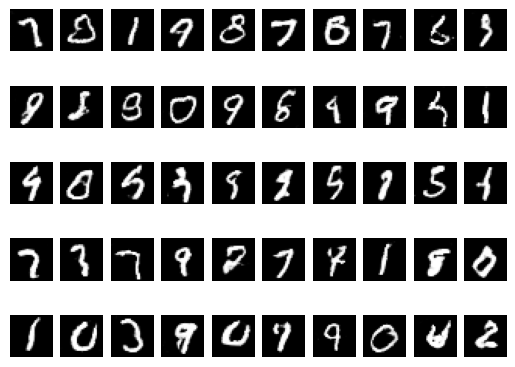

In [17]:
# Generating the images
images = generate_image(generator, n_images=50, seeded=True)

# Visualizing the images
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(images[i].squeeze().detach().cpu().numpy(), cmap='gray')
    plt.axis('off')

plt.savefig('images//generated_images.png', dpi=300, bbox_inches='tight')
plt.show()

It looks alright, but far from perfect. It kinda looks as if someone drunk is writing the digits. Might need to re-tune the structure or hyperparameters.

### Discriminator accuracy

In [18]:
# Getting a batch of real images
real_images, _ = next(iter(train_dataloader))

# Creating a batch of fake images
fake_images = generate_image(generator, n_images=batch_size, seeded=True)

# Calculating the accuracy of the discriminator
accuracy = (torch.sum(discriminator(real_images) > 0.5) + torch.sum(discriminator(fake_images) < 0.5)) / (len(real_images) + len(fake_images))

# Printing the accuracy
print('Accuracy of the discriminator: %.2f%%' % (accuracy * 100))

Accuracy of the discriminator: 85.94%


## References

- [Deep Convolutional GANs by Alec Radford, Luke Metz, Soumith Chintala](https://arxiv.org/abs/1511.06434)
- Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow 3rd edition by Aurelien Geron